Need to restart the kernal to run each pollutant

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
from glob import glob

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import *
from tensorflow.keras import Sequential
from utils import * 

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 2

plt.rcParams['savefig.dpi'] = 400
plt.rcParams['font.size'] = 13
plt.rcParams["legend.frameon"] = False

In [2]:
#import dataset
data = pd.read_csv("datacopy.csv")
data = np.array(data)

# LSTM_PM2.5

### 1. data preprocssing: prepare data for training & test sets

#### import data as training & test sets

In [3]:
X_train_df = data[0:int(len(data)*0.8),8:12]
y_train_df = data[0:int(len(data)*0.8),1]

X_test_df = data[int(len(data)*0.8):int(len(data)),8:12]
y_test_df = data[int(len(data)*0.8):int(len(data)),1]

#### Data normalization

In [4]:
#Standardization
mean, std = X_train_df.mean(), X_train_df.std()

X_train_df   = (X_train_df - mean)/std
X_test_df    = (X_test_df - mean)/std

X_train = X_train_df
y_train = y_train_df
X_test = X_test_df

y_train = y_train.reshape(7008,1)
print(X_train.shape,y_train.shape,X_test.shape)

(7008, 4) (7008, 1) (1752, 4)


#### Reshape data to feed into the LSTM model

The LSTM needs data with the format of **[samples, time steps, features]**

In [5]:
X_length = X_train.shape[0]

slider = 24
X_train_all = []
y_train_all = []
X_test_all = []

#for i in range(len(X_length)):
    
    #X_subset = X_train[start[i]:end[i],:]
    #y_subset = y_train[start[i]:end[i],:]
    
X_subset = np.array([X_train[i:i+slider] for i in range(0, 7008,24)])
X_train_all.append(X_subset)   
X_train = np.concatenate(X_train_all,axis=0)

y_subset = np.array([y_train[i:i+slider] for i in range(0, 7008,24)])
y_train_all.append(y_subset)
y_train = np.concatenate(y_train_all,axis=0)

X_subset_test = np.array([X_test[i:i+slider] for i in range(0, 1752,24)])
X_test_all.append(X_subset_test)
X_test = np.concatenate(X_test_all,axis=0)


print(X_train.shape,y_train.shape,X_test.shape)

(292, 24, 4) (292, 24, 1) (73, 24, 4)


### 2. Define the LSTM structure

In [6]:
# set hyperparameters
n_neuron       = 64
activation     = 'relu'
num_epochs     = 100
learning_rate  = 0.001
minibatch_size = 64
model_num      = 1

In [7]:
lstm_model = Sequential()
lstm_model.add(LSTM(n_neuron,input_shape=(X_train.shape[1],X_train.shape[2]),
               return_sequences=True,activation=activation))
lstm_model.add(LSTM(n_neuron,return_sequences=False,
               activation=activation))
lstm_model.add(Dense(n_neuron,activation=activation))
lstm_model.add(Dense(y_train.shape[-1],activation='linear')) 

lstm_model.compile(loss='mse',optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate))

lstm_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 24, 64)            17664     
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 54,913
Trainable params: 54,913
Non-trainable params: 0
_________________________________________________________________


2022-12-20 18:34:39.457345: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### 3. Train & save the NN model

In [8]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)

history = lstm_model.fit(X_train, y_train, 
                        batch_size = minibatch_size,
                        epochs = num_epochs,
                        validation_split=0.2, verbose=1,
                        callbacks=[early_stop],
                        shuffle=False)


Epoch 1/100
4/4 [==============================] - 1s 77ms/step - loss: 250.9590 - val_loss: 262.6757
Epoch 2/100
4/4 [==============================] - 0s 25ms/step - loss: 242.5552 - val_loss: 245.5796
Epoch 3/100
4/4 [==============================] - 0s 24ms/step - loss: 218.0972 - val_loss: 173.3801
Epoch 4/100
4/4 [==============================] - 0s 25ms/step - loss: 167.9563 - val_loss: 110.7194
Epoch 5/100
4/4 [==============================] - 0s 25ms/step - loss: 128.3238 - val_loss: 70.2671
Epoch 6/100
4/4 [==============================] - 0s 24ms/step - loss: 105.5206 - val_loss: 75.8849
Epoch 7/100
4/4 [==============================] - 0s 25ms/step - loss: 95.9092 - val_loss: 61.0930
Epoch 8/100
4/4 [==============================] - 0s 25ms/step - loss: 100.8243 - val_loss: 69.3136
Epoch 9/100
4/4 [==============================] - 0s 24ms/step - loss: 92.7139 - val_loss: 62.6323
Epoch 10/100
4/4 [==============================] - 0s 25ms/step - loss: 92.4119 - val_lo

4/4 [==============================] - 0s 25ms/step - loss: 82.0816 - val_loss: 57.3256
Epoch 83/100
4/4 [==============================] - 0s 25ms/step - loss: 81.2126 - val_loss: 58.8164
Epoch 84/100
4/4 [==============================] - 0s 25ms/step - loss: 84.1300 - val_loss: 55.4223
Epoch 85/100
4/4 [==============================] - 0s 24ms/step - loss: 84.8114 - val_loss: 59.3275
Epoch 86/100
4/4 [==============================] - 0s 25ms/step - loss: 82.0883 - val_loss: 63.2634
Epoch 87/100
4/4 [==============================] - 0s 25ms/step - loss: 82.4400 - val_loss: 56.6638
Epoch 88/100
4/4 [==============================] - 0s 25ms/step - loss: 82.2168 - val_loss: 55.5261


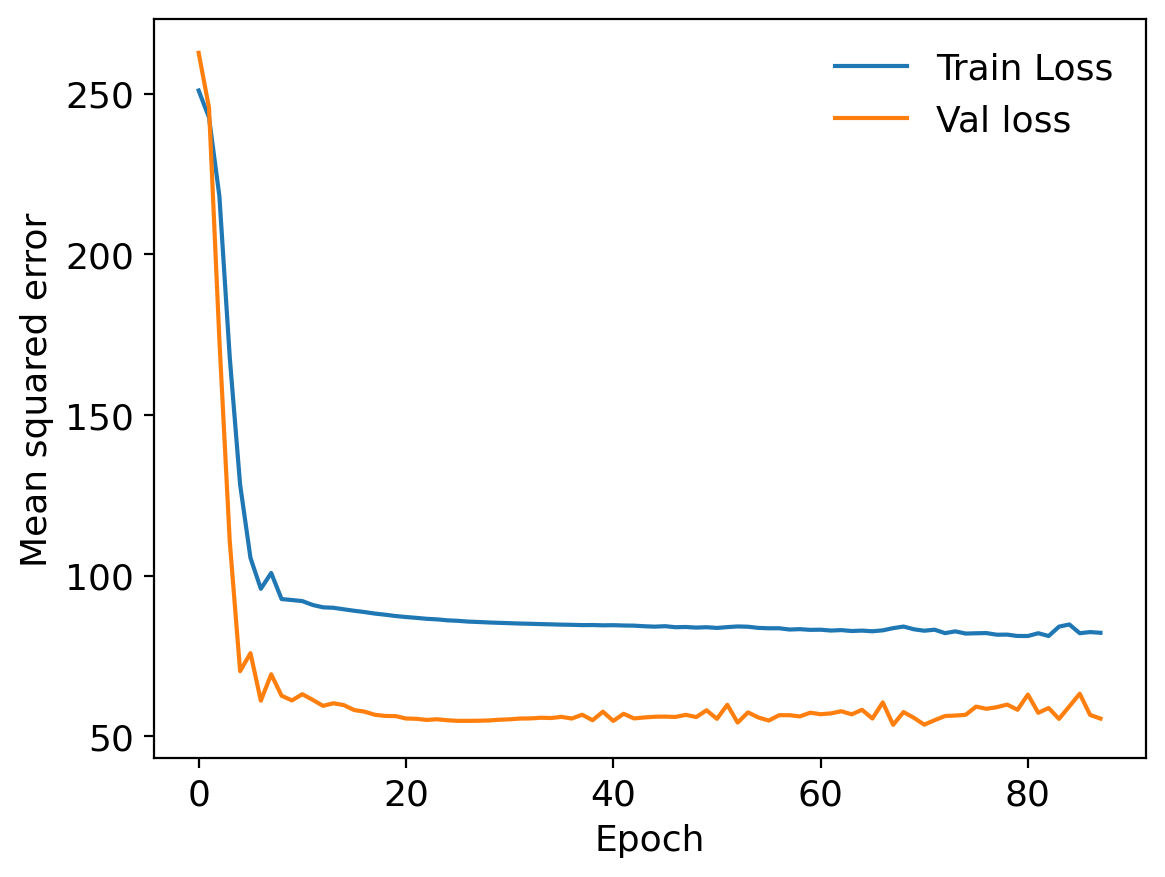

In [9]:
plot_history(history)

# LSTM_NOx

### 1. data preprocssing: prepare data for training & test sets

#### import data as training & test sets

In [3]:
X_train_df = data[0:int(len(data)*0.8),8:12]
y_train_df = data[0:int(len(data)*0.8),2]

X_test_df = data[int(len(data)*0.8):int(len(data)),8:12]
y_test_df = data[int(len(data)*0.8):int(len(data)),2]

#### Data normalization

In [4]:
#Standardization
mean, std = X_train_df.mean(), X_train_df.std()

X_train_df   = (X_train_df - mean)/std
X_test_df    = (X_test_df - mean)/std

X_train = X_train_df
y_train = y_train_df
X_test = X_test_df

y_train = y_train.reshape(7008,1)
print(X_train.shape,y_train.shape,X_test.shape)

(7008, 4) (7008, 1) (1752, 4)


#### Reshape data to feed into the LSTM model

The LSTM needs data with the format of **[samples, time steps, features]**

In [5]:
X_length = X_train.shape[0]

slider = 24
X_train_all = []
y_train_all = []
X_test_all = []

#for i in range(len(X_length)):
    
    #X_subset = X_train[start[i]:end[i],:]
    #y_subset = y_train[start[i]:end[i],:]
    
X_subset = np.array([X_train[i:i+slider] for i in range(0, 7008,24)])
X_train_all.append(X_subset)   
X_train = np.concatenate(X_train_all,axis=0)

y_subset = np.array([y_train[i:i+slider] for i in range(0, 7008,24)])
y_train_all.append(y_subset)
y_train = np.concatenate(y_train_all,axis=0)

X_subset_test = np.array([X_test[i:i+slider] for i in range(0, 1752,24)])
X_test_all.append(X_subset_test)
X_test = np.concatenate(X_test_all,axis=0)


print(X_train.shape,y_train.shape,X_test.shape)

(292, 24, 4) (292, 24, 1) (73, 24, 4)


### 2. Define the LSTM structure

In [6]:
# set hyperparameters
n_neuron       = 64
activation     = 'relu'
num_epochs     = 100
learning_rate  = 0.001
minibatch_size = 64
model_num      = 1

In [7]:
lstm_model = Sequential()
lstm_model.add(LSTM(n_neuron,input_shape=(X_train.shape[1],X_train.shape[2]),
               return_sequences=True,activation=activation))
lstm_model.add(LSTM(n_neuron,return_sequences=False,
               activation=activation))
lstm_model.add(Dense(n_neuron,activation=activation))
lstm_model.add(Dense(y_train.shape[-1],activation='linear')) 

lstm_model.compile(loss='mse',optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate))

lstm_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 24, 64)            17664     
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 54,913
Trainable params: 54,913
Non-trainable params: 0
_________________________________________________________________


2022-12-22 10:26:22.111686: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### 3. Train & save the NN model

In [8]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)

history = lstm_model.fit(X_train, y_train, 
                        batch_size = minibatch_size,
                        epochs = num_epochs,
                        validation_split=0.2, verbose=1,
                        callbacks=[early_stop],
                        shuffle=False)


Epoch 1/100
4/4 [==============================] - 1s 76ms/step - loss: 666.9605 - val_loss: 850.0891
Epoch 2/100
4/4 [==============================] - 0s 25ms/step - loss: 657.4838 - val_loss: 834.7766
Epoch 3/100
4/4 [==============================] - 0s 24ms/step - loss: 640.2063 - val_loss: 792.5623
Epoch 4/100
4/4 [==============================] - 0s 25ms/step - loss: 574.3286 - val_loss: 484.2435
Epoch 5/100
4/4 [==============================] - 0s 24ms/step - loss: 399.7871 - val_loss: 341.6331
Epoch 6/100
4/4 [==============================] - 0s 24ms/step - loss: 306.6141 - val_loss: 286.3331
Epoch 7/100
4/4 [==============================] - 0s 24ms/step - loss: 270.0643 - val_loss: 249.5401
Epoch 8/100
4/4 [==============================] - 0s 24ms/step - loss: 220.9709 - val_loss: 266.1386
Epoch 9/100
4/4 [==============================] - 0s 24ms/step - loss: 198.5562 - val_loss: 242.4087
Epoch 10/100
4/4 [==============================] - 0s 24ms/step - loss: 177.9084 

4/4 [==============================] - 0s 25ms/step - loss: 128.3917 - val_loss: 169.4664
Epoch 81/100
4/4 [==============================] - 0s 24ms/step - loss: 127.8343 - val_loss: 181.1915
Epoch 82/100
4/4 [==============================] - 0s 25ms/step - loss: 128.8442 - val_loss: 182.6385
Epoch 83/100
4/4 [==============================] - 0s 24ms/step - loss: 126.7638 - val_loss: 167.1250
Epoch 84/100
4/4 [==============================] - 0s 24ms/step - loss: 129.4568 - val_loss: 201.1119
Epoch 85/100
4/4 [==============================] - 0s 24ms/step - loss: 141.7901 - val_loss: 176.6455
Epoch 86/100
4/4 [==============================] - 0s 24ms/step - loss: 130.0479 - val_loss: 169.7836
Epoch 87/100
4/4 [==============================] - 0s 24ms/step - loss: 134.8130 - val_loss: 211.5532


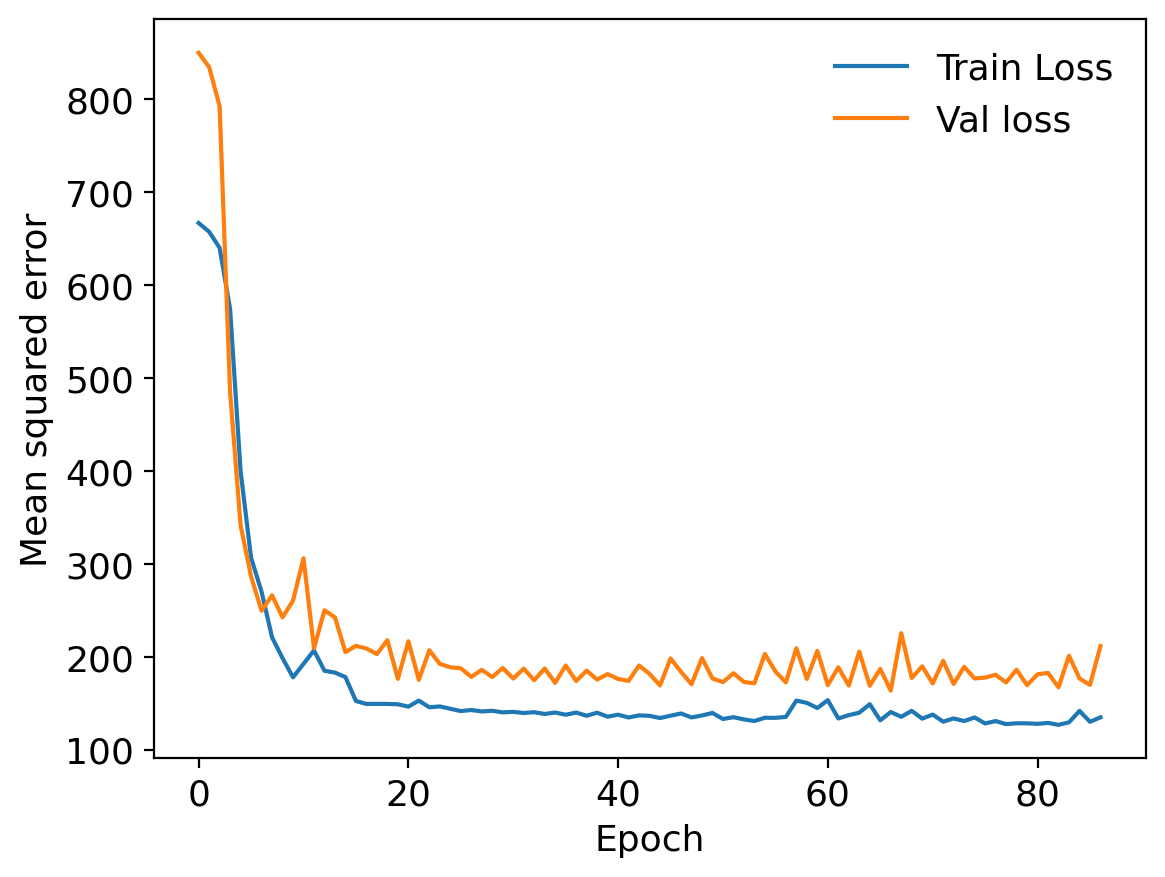

In [9]:
plot_history(history)

# LSTM_SO2

### 1. data preprocssing: prepare data for training & test sets

#### import data as training & test sets

In [3]:
X_train_df = data[0:int(len(data)*0.8),8:12]
y_train_df = data[0:int(len(data)*0.8),3]

X_test_df = data[int(len(data)*0.8):int(len(data)),8:12]
y_test_df = data[int(len(data)*0.8):int(len(data)),3]

#### Data normalization

In [4]:
#Standardization
mean, std = X_train_df.mean(), X_train_df.std()

X_train_df   = (X_train_df - mean)/std
X_test_df    = (X_test_df - mean)/std

X_train = X_train_df
y_train = y_train_df
X_test = X_test_df

y_train = y_train.reshape(7008,1)
print(X_train.shape,y_train.shape,X_test.shape)

(7008, 4) (7008, 1) (1752, 4)


#### Reshape data to feed into the LSTM model

The LSTM needs data with the format of **[samples, time steps, features]**

In [5]:
X_length = X_train.shape[0]

slider = 24
X_train_all = []
y_train_all = []
X_test_all = []

#for i in range(len(X_length)):
    
    #X_subset = X_train[start[i]:end[i],:]
    #y_subset = y_train[start[i]:end[i],:]
    
X_subset = np.array([X_train[i:i+slider] for i in range(0, 7008,24)])
X_train_all.append(X_subset)   
X_train = np.concatenate(X_train_all,axis=0)

y_subset = np.array([y_train[i:i+slider] for i in range(0, 7008,24)])
y_train_all.append(y_subset)
y_train = np.concatenate(y_train_all,axis=0)

X_subset_test = np.array([X_test[i:i+slider] for i in range(0, 1752,24)])
X_test_all.append(X_subset_test)
X_test = np.concatenate(X_test_all,axis=0)


print(X_train.shape,y_train.shape,X_test.shape)

(292, 24, 4) (292, 24, 1) (73, 24, 4)


### 2. Define the LSTM structure

In [6]:
# set hyperparameters
n_neuron       = 64
activation     = 'relu'
num_epochs     = 100
learning_rate  = 0.001
minibatch_size = 64
model_num      = 1

In [7]:
lstm_model = Sequential()
lstm_model.add(LSTM(n_neuron,input_shape=(X_train.shape[1],X_train.shape[2]),
               return_sequences=True,activation=activation))
lstm_model.add(LSTM(n_neuron,return_sequences=False,
               activation=activation))
lstm_model.add(Dense(n_neuron,activation=activation))
lstm_model.add(Dense(y_train.shape[-1],activation='linear')) 

lstm_model.compile(loss='mse',optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate))

lstm_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 24, 64)            17664     
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 54,913
Trainable params: 54,913
Non-trainable params: 0
_________________________________________________________________


2022-12-22 10:27:32.260629: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### 3. Train & save the NN model

In [8]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)

history = lstm_model.fit(X_train, y_train, 
                        batch_size = minibatch_size,
                        epochs = num_epochs,
                        validation_split=0.2, verbose=1,
                        callbacks=[early_stop],
                        shuffle=False)


Epoch 1/100
4/4 [==============================] - 1s 78ms/step - loss: 1.6177 - val_loss: 1.6725
Epoch 2/100
4/4 [==============================] - 0s 27ms/step - loss: 1.2975 - val_loss: 1.4583
Epoch 3/100
4/4 [==============================] - 0s 26ms/step - loss: 1.1621 - val_loss: 1.5065
Epoch 4/100
4/4 [==============================] - 0s 26ms/step - loss: 1.1154 - val_loss: 1.4517
Epoch 5/100
4/4 [==============================] - 0s 26ms/step - loss: 1.1163 - val_loss: 1.4507
Epoch 6/100
4/4 [==============================] - 0s 28ms/step - loss: 1.1060 - val_loss: 1.4462
Epoch 7/100
4/4 [==============================] - 0s 27ms/step - loss: 1.0868 - val_loss: 1.4656
Epoch 8/100
4/4 [==============================] - 0s 26ms/step - loss: 1.0823 - val_loss: 1.4491
Epoch 9/100
4/4 [==============================] - 0s 24ms/step - loss: 1.0751 - val_loss: 1.4309
Epoch 10/100
4/4 [==============================] - 0s 25ms/step - loss: 1.0731 - val_loss: 1.4279
Epoch 11/100
4/4 [=

Epoch 84/100
4/4 [==============================] - 0s 23ms/step - loss: 1.0128 - val_loss: 1.3971
Epoch 85/100
4/4 [==============================] - 0s 24ms/step - loss: 1.0144 - val_loss: 1.4099
Epoch 86/100
4/4 [==============================] - 0s 24ms/step - loss: 1.0097 - val_loss: 1.4016
Epoch 87/100
4/4 [==============================] - 0s 23ms/step - loss: 1.0143 - val_loss: 1.4080
Epoch 88/100
4/4 [==============================] - 0s 23ms/step - loss: 1.0194 - val_loss: 1.4411
Epoch 89/100
4/4 [==============================] - 0s 23ms/step - loss: 1.0146 - val_loss: 1.3956
Epoch 90/100
4/4 [==============================] - 0s 23ms/step - loss: 1.0379 - val_loss: 1.4404
Epoch 91/100
4/4 [==============================] - 0s 24ms/step - loss: 1.0154 - val_loss: 1.3783
Epoch 92/100
4/4 [==============================] - 0s 23ms/step - loss: 1.0165 - val_loss: 1.4184
Epoch 93/100
4/4 [==============================] - 0s 23ms/step - loss: 1.0138 - val_loss: 1.3827
Epoch 94/1

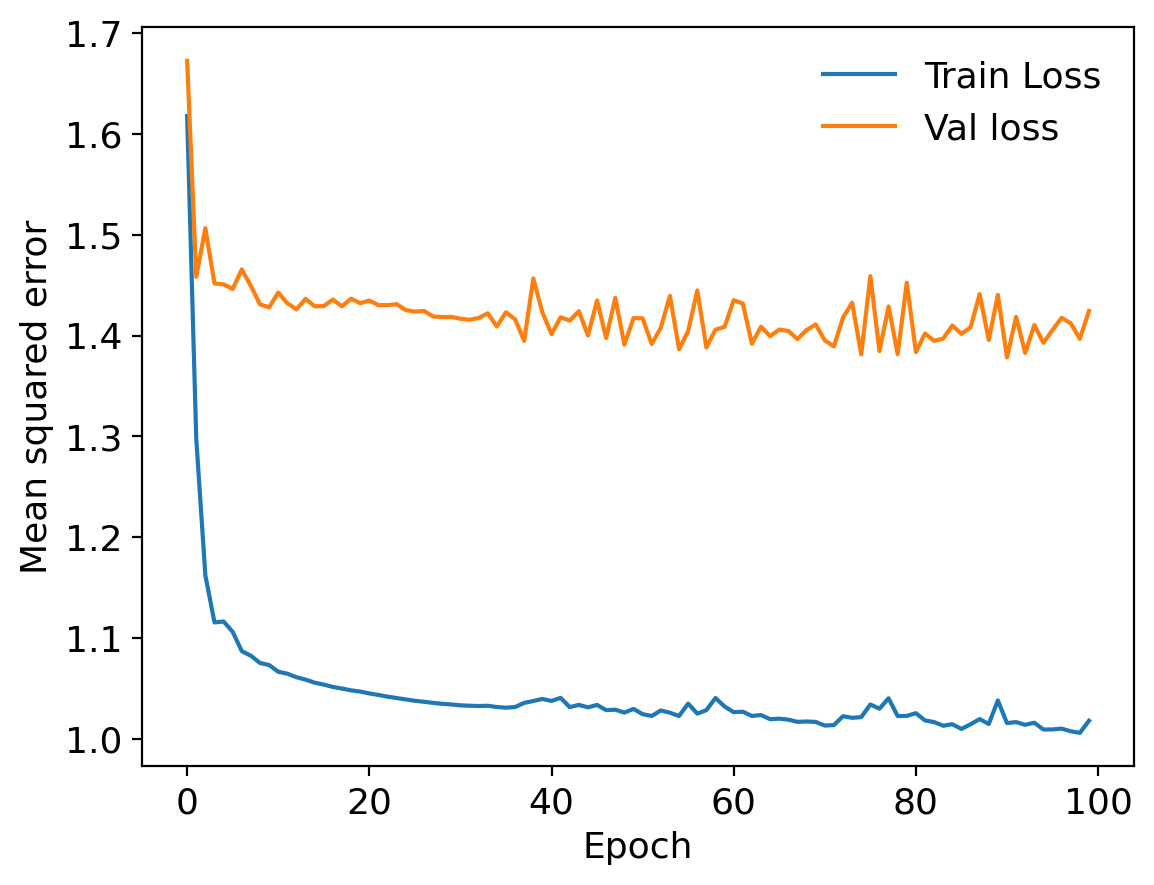

In [9]:
plot_history(history)